# Plot system_test_fast_results.csv

This notebook loads the results from `system_test_fast_results.csv` and plots the columns by frame index.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
# Read the CSV results
video_name = "FH402_01"
df = pd.read_csv(f'processed_{video_name}.csv')
df['prob_diff'] = df['prob_diff'].abs()
df.head()

,frame_idx,diff_score,pos_prob,prob_diff
0,1,0.044395,0.361800,NaN
1,2,0.044818,0.167049,0.194752
2,3,0.053528,0.500350,0.333301
3,4,0.049391,0.332000,0.168350
4,5,0.045141,0.336095,0.004095


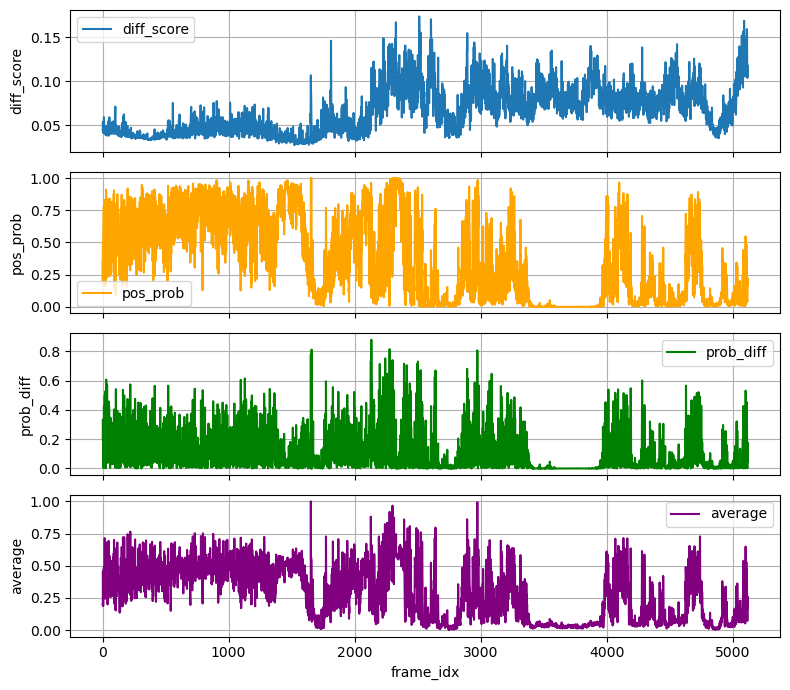

In [54]:
# Add a fourth plot for the average of diff_score, pos_prob, and prob_diff
weights = [0.4, 0.3, 0.3]
df['average'] = df[['diff_score', 'pos_prob', 'prob_diff']].mul(weights, axis=1).sum(axis=1)
df['average'] = (df['average'] - df['average'].min()) / (df['average'].max() - df['average'].min())

fig, axs = plt.subplots(4, 1, figsize=(8, 7), sharex=True)

axs[0].plot(df['frame_idx'], df['diff_score'], label='diff_score')
axs[0].set_ylabel('diff_score')
axs[0].legend()

axs[1].plot(df['frame_idx'], df['pos_prob'], label='pos_prob', color='orange')
axs[1].set_ylabel('pos_prob')
axs[1].legend()

axs[2].plot(df['frame_idx'], df['prob_diff'], label='prob_diff', color='green')
axs[2].set_ylabel('prob_diff')
axs[2].legend()

axs[3].plot(df['frame_idx'], df['average'], label='average', color='purple')
axs[3].set_ylabel('average')
axs[3].set_xlabel('frame_idx')
axs[3].legend()

for ax in axs:
    ax.grid(True)

plt.tight_layout()
plt.show()

## Extract ground truth for video and mark on plots

In [41]:
# Load ground truth CSV and extract FH401_01 rows
gt = pd.read_csv('./data/Weinstein2018MEE_ground_truth.csv')
gt_video = gt[gt['Video'] == 'FH303_01']
gt_video = gt_video.set_index('Frame', drop=False)

# deduplicate the index of ground truth
gt_video = gt_video[~gt_video.index.duplicated(keep='first')]
gt_video[['Frame', 'Truth']]

,Frame,Truth
Frame,,
2,2,Negative
3,3,Negative
426,426,Negative
1378,1378,Negative
1379,1379,Negative
...,...,...
20544,20544,Positive
20550,20550,Positive
20551,20551,Positive


/var/folders/c0/41nq7l9n3131kxqmzmk4h_nh0000gn/T/ipykernel_51088/395378014.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


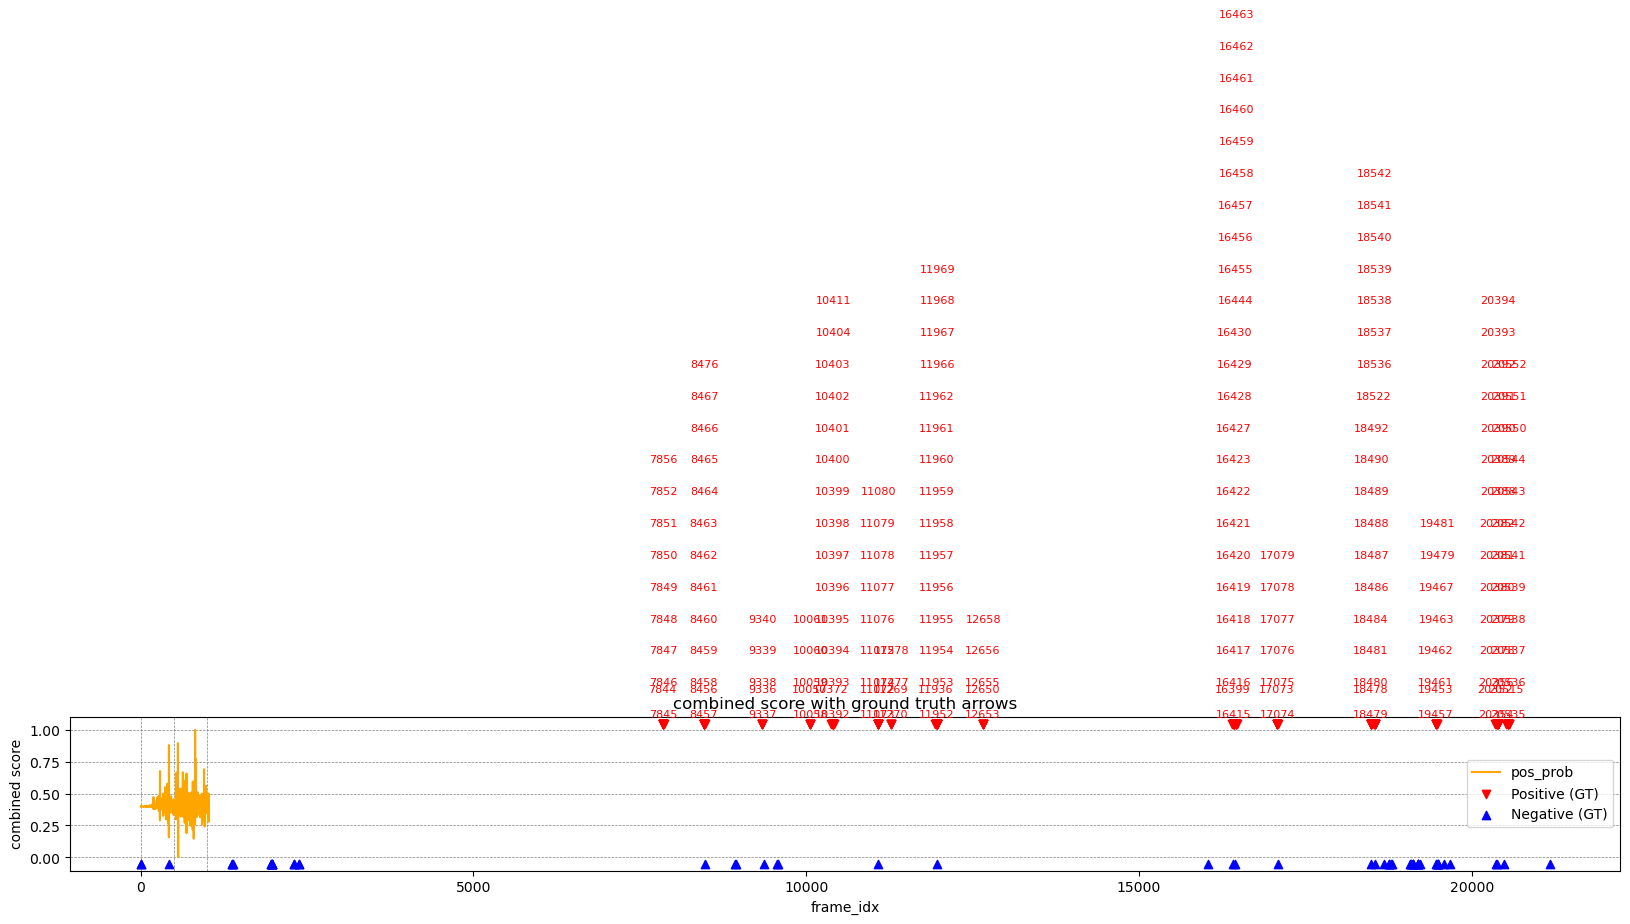

In [42]:
# Plot pos_prob with ground truth arrows for FH401_01
fig, ax = plt.subplots(figsize=(20, 2))
ax.plot(df['frame_idx'], df['average'], label='pos_prob', color='orange')
for x in range(1, df['frame_idx'].max(), 500):
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.5, zorder=0)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, color='gray', zorder=0)

# Only plot if ground truth is available
if not gt_video.empty:
    # Arrow up for Positive, arrow down for Negative
    positives = gt_video[gt_video['Truth'].str.lower() == 'positive']
    negatives = gt_video[gt_video['Truth'].str.lower() == 'negative']
    ax.scatter(positives['Frame'], [1.05]*len(positives), marker='v', color='red', label='Positive (GT)', zorder=5)
    ax.scatter(negatives['Frame'], [-0.05]*len(negatives), marker='^', color='blue', label='Negative (GT)', zorder=5)
    
    # Annotate positive markers with frame IDs, spreading out text if labels are close
    last_frame_id = None
    c=0
    for frame_id in positives['Frame']:
        if last_frame_id is not None and abs(frame_id - last_frame_id) < 100:  # Adjust threshold as needed
            offset = 1.1 + 0.25 * c# Add fixed offset of 1 if condition is true
            ax.text(frame_id, offset, str(frame_id), color='red', fontsize=8, ha='center')  # Spread out
            c += 1
        else:
            c = 0
            ax.text(frame_id, 1.3, str(frame_id), color='red', fontsize=8, ha='center')
        last_frame_id = frame_id

ax.set_ylabel('combined score')
ax.set_xlabel('frame_idx')
ax.legend()

plt.title('combined score with ground truth arrows')
plt.tight_layout()
plt.show()

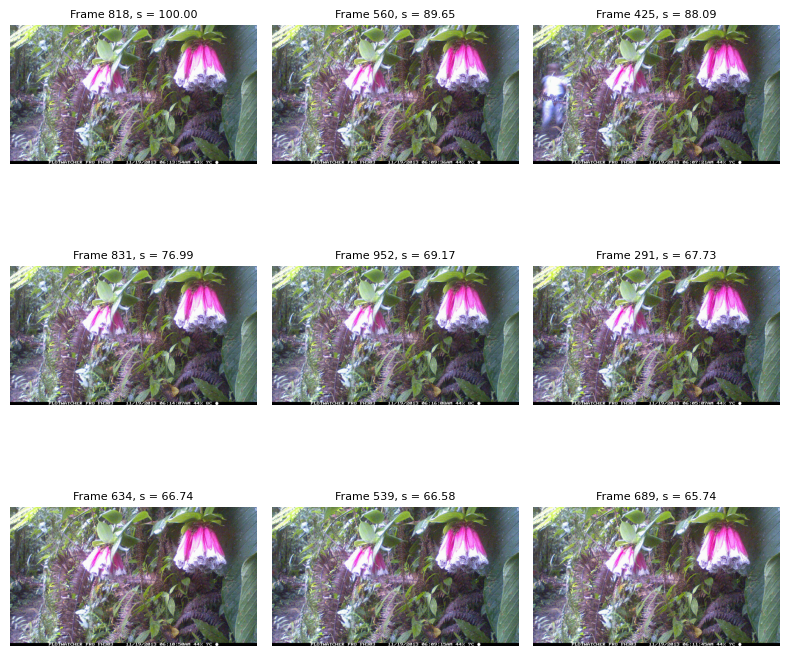

In [43]:
from torchcodec.decoders import VideoDecoder
import numpy as np

top_k = 9
# Get the top 10 rows with the highest 'average' values
top_k_frames = df.nlargest(top_k, 'average')['frame_idx']

# Assuming you have a function or method to extract frames from the video
# For example, using torchcodec to read frames from a video file

video_path = 'data/FH303_01.avi'  # Replace with the actual video file path
decoder = VideoDecoder(video_path)

frames = []
for frame_idx in top_k_frames:
    frame = decoder[frame_idx]  # Seek to the frame (0-based index)
    frames.append((frame_idx, frame))


# Display the extracted frames using matplotlib on a [3, 3] grid
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()  # Flatten the 2D array of axes for easier iteration

for ax, (frame_idx, frame) in zip(axs, frames):
    ax.imshow(np.transpose(frame, [1, 2, 0]))  # Assuming frame is in CHW format, convert to HWC for matplotlib
    ax.set_title(f'Frame {frame_idx}, s = {df.loc[df["frame_idx"] == frame_idx, "average"].values[0]*100:.2f}', fontsize=8)
    ax.axis('off')

# Hide any unused subplots
for ax in axs[len(frames):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [44]:
# Create a DataFrame to store the results
results = []
buff = 10
# Iterate through all top_10_frames
for frame in top_10_frames:
    is_within_range = any((positives['Frame'] >= frame - buff) & (positives['Frame'] <= frame + buff))
    results.append({'Frame': frame, 'Within ±5 of Positive GT': is_within_range})

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the table
print(results_df)

NameError: name 'top_10_frames' is not defined